<a href="https://colab.research.google.com/github/applejxd/colaboratory/blob/master/algorithm/RANSAC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

基本設定

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=[10,10])

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

誤差分布は外れ値が大きいコーシー分布

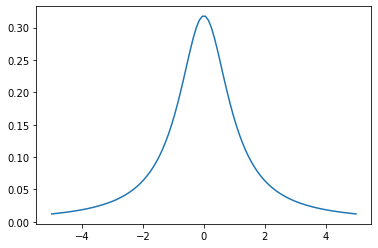

In [12]:
import numpy as np

def cauchy(x: np.ndarray):
    return 1/np.pi/(1+x*x)

x = np.linspace(-5, 5, 100)
y = cauchy(x)

plt.plot(x, y)
plt.show()

サンプルデータ生成

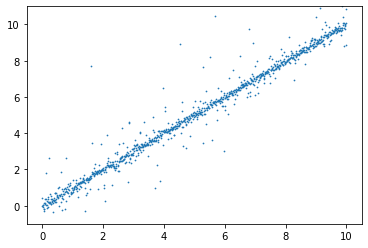

In [13]:
point_num: int = 1000

errors = np.random.standard_cauchy(point_num)
x = np.linspace(0, 10, point_num)
y = x + errors / 10

points = np.vstack([x, y]).T

plt.scatter(x, y, s=0.5)
plt.ylim(-1, 11)
plt.show()

ランダムサンプリング

In [14]:
index_mat = np.random.randint(0, point_num, (point_num, 2))
print(index_mat)

[[265 442]
 [136 779]
 [480 714]
 ...
 [ 27 985]
 [621 555]
 [726 550]]


In [15]:
# 転置前の成分数は (axis, samples, points)
samples_tensor = np.array([x[index_mat], y[index_mat]]).transpose(1, 0, 2)

print(samples_tensor.shape)
print(samples_tensor)

(1000, 2, 2)
[[[2.65265265 4.42442442]
  [2.54671797 4.51506578]]

 [[1.36136136 7.7977978 ]
  [1.291343   7.5832177 ]]

 [[4.8048048  7.14714715]
  [4.7762626  7.08325442]]

 ...

 [[0.27027027 9.85985986]
  [0.65636094 9.80894448]]

 [[6.21621622 5.55555556]
  [6.33513774 5.85773077]]

 [[7.26726727 5.50550551]
  [7.22678761 5.72207779]]]


傾きと切片計算

In [16]:
def get_params(samples):
    point1, point2 = samples[0], samples[1]
    grad = (point2[1] - point1[1])/(point2[0] - point1[0])
    line_slice = point1[1] - grad * point1[0]
    return grad, line_slice

params_tensor = np.array([get_params(sample) for sample in samples_tensor])

inlier の数を計算 → 最も良い候補を選択

In [17]:
def get_distances(params, points):
    y_est = params[0] * points[:, 0] + params[1]
    distances = np.abs(points[:, 1] - y_est)
    return distances

distances_tensor = np.array([
    get_distances(params, points) for params in params_tensor])

distance_th = 0.3
inlier_bool_tensor = np.array([
    distances < distance_th
    for distances in distances_tensor
])
inlier_num_array = np.array([
    np.sum(inlier_bool)
    for inlier_bool in inlier_bool_tensor
])

best_idx = np.argmax(inlier_num_array)
print(best_idx)

962


結果を確認

In [18]:
best_params = params_tensor[best_idx]
inlier_idx = np.arange(point_num)[inlier_bool_tensor[best_idx]]
outlier_idx = np.arange(point_num)[~inlier_bool_tensor[best_idx]]

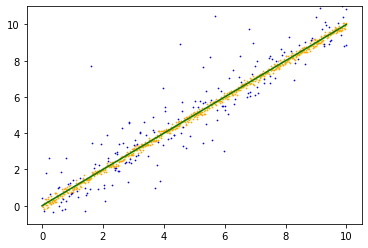

In [19]:
plt.scatter(points[inlier_idx, 0], points[inlier_idx, 1], s=0.5, color="orange")
plt.scatter(points[outlier_idx, 0], points[outlier_idx, 1], s=0.5, color="blue")

plt.plot(points[:, 0], best_params[0]*points[:, 0]+best_params[1],
         color="green")
plt.ylim(-1, 11)
plt.show()

再フィッティング

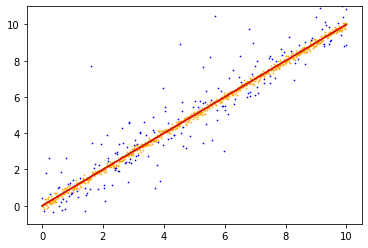

In [21]:
grad, line_slice = np.polyfit(points[inlier_idx, 0], points[inlier_idx, 1], 1)

plt.scatter(points[inlier_idx, 0], points[inlier_idx, 1], s=0.5, color="orange")
plt.scatter(points[outlier_idx, 0], points[outlier_idx, 1], s=0.5, color="blue")
plt.plot(points[:, 0], best_params[0]*points[:, 0]+best_params[1],
         color="green")
plt.plot(points[:, 0], grad*points[:, 0]+line_slice,
         color="red")
plt.ylim(-1, 11)
plt.show()